# w261 Final Project - Click-through Rate Prediction


Team 14   
Brian Musisi, Pri Nonis, Vinicio Del Sola, Laura Chutny   
Fall 2019, Section 3

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

## 1.1 Question

Advertisers on websites make money when people click on an ad, visit the advertiser's site and then purchase something. This means that understanding the rate (or probability) at which people click on an ad is important - higher 'click-through' rates have the potential for more revenue. This study will not address the next step, which is how an advertiser converts a person who has 'clicked-through' to their site into a paying customer. Instead, our question is how to predict the click through rate for a given (unseen) ad based on the training data supplied to the model. In other words, for a given ad, what is the probability that a person will click on the ad? Ads cost money, so advertisers need to know which ads will generate more clicks and thus which ads are more valuable to the advertiser.

## 1.2 Data

In 2014, Criteo introduced a Click Through Rate challenge on Kaggle [**2**], using a set of ads served by Criteo[**1**]. Each line is the serving of one ad and the training set comes from a period of 7 days. They are labeled as 1 if the ad was clicked on and 0 if the ad was not. The data was subsampled before being placed into the competition, so the dataset is smaller, and the percentage of '1's are higher than in the original data. This is the dataset we will use for the analysis in this report. Note that we will not submit to the Kaggle competition and we are not using their testing data, only the training set. Click Through Rate is defined as the number of ads that are clicked on as a fraction of the total impressions of ads that are viewed. In this case, each example in the dataset is an impression of the ad.


This is a classification problem - a 'positive' result (1) if the ad is clicked on and a 'negative' result (0) if the ad is not clicked on. There is a large imbalance between classes - far more impressions (views of the ad) with no click (0) than impressions which result in a click (1). In this instance we need to decide between false positives (type 1 error - where we predict a click that did not actually happen) and false negatives (type 2 errors - where we do not predict a click when there actually was one). Because advertisers pay more for ads that are clicked, we want to be conservative in our predictions, and avoid false positives.

The data itself is a combination of numerical and categorical features. Each row contains the label ($y$) which is either 1, or 0. Next are 13 numerical variables, i01-i13, which contain positive, negative and zero valued integers. Finally, there are 26 columns of categorical features - c1-c26. The values of these features have been hashed onto 32 bits for anonymization purposes. We have no descriptors of the data columns or features, and no indication if it was originally ranked data or not, and thus we have chosen to approach it as if unranked. All decisions in feature engineering are made purely from the frequency and relative importance of the feature values, as there is no subject matter expertise to inform feature selection. There are 45,842,555 total examples in the dataset.

## 1.3 Evaluation Metric   

Finally, we must consider how we will evaluate the performance of our model(s). For evaulation of binary classification, especially with the (potentially) highly skewed values in a click-through rate problem, accuracy is not a good measure. For example, we could have excellent accuracy by predicting 100% of the test examples as 0, while the true number might be 96% - so we would have a great accuracy of 96%, but in actual fact, we would have missed out predicting the actual positive values in the remaining 4%. 

Note that below, TP = True Positive, FP = False Positive, TN = True Negative and FN = False Negative.  

Instead, if we set a goal of limiting the false positive predictions, precision, defined as $P = \dfrac{TP}{(TP + FP)}$ will work well. We would trade gains in precision with minimizing the number of false negatives, otherwise known as sensitivity or recall: $R = \dfrac{TP}{(TP + FN)}$. Luckily for us, there is a nice metric that is defined as the 'F-score' which combines the optimized precision and sensitivity, and we get: $F = 2\cdot \dfrac{P\cdot R}{P+R}$. F-score would be a perfectly acceptable metric to use, except it is a single number.

When we are optimizing over hyperparameters, we would like to understand a little better what the optimum is for different ratios of true and false positives. If we plot the way the true and false positive rates change for a given model, we get what is known as a 'receiver operating characteristic curve' (or ROC curve) as shown in Figure 1. The ROC plots the true-positive rate against the false-positive rate. As the ROC becomes more concave, the achievable true positive rate for a given false positive rate increases, as does the area under the curve (AUC). In the following diagram, curve 'A' has a larger AUC and as can be seen, a higher true positive rate for a given false positive rate.


<figure>
  <img src="assets/ROC.png" width="350">
    <figcaption> <b>Figure 1. Receiver Operating Characteristic Curve [3]</b> </figcaption>
</figure>




Another way to say this, as summarized on Wikipedia [__4__], is that the AUC is "equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one".  The 2nd place winner of the Criteo Kaggle competition had an AUC of 0.8097 [__5__], also another attempt at prediction on the Criteo dataset reported an AUC of 0.79 [__6__].  Given this data, we believe that obtaining an AUC of 0.75 or better would be a really useful result for advertisers.
See [**7**] for more details.

__References - Section 1__  

[1] “Kaggle Display Advertising Challenge Dataset,” Criteo Labs, 10-Feb-2014. [Online]. Available: https://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset/. [Accessed: 11-Dec-2019].  
[2] “Display Advertising Challenge.” [Online]. Available: https://kaggle.com/c/criteo-display-ad-challenge. [Accessed: 11-Dec-2019].  
[3] M. E. Cross and E. V. E. Plunkett, “Receiver operating characteristic curve,” in Physics, Pharmacology and Physiology for Anaesthetists: Key Concepts for the FRCA, 2nd ed., Cambridge: Cambridge University Press, 2014, pp. 369–369.  
[4] “Receiver Operating Characteristic,” wikipedia.org, Nov-2019. [Online]. Available: https://en.wikipedia.org/wiki/Receiver_operating_characteristic.<br/>
[5] M. Jahrer, “Can anyone tell me the AUC of benchmark model ?,” kaggle.com, 2014. [Online]. Available: https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/9821.<br/>
[6] wormhole developers, “Binary Classification on the Criteo CTR Dataset,” wormhole.readthedocs.io, 2015. [Online]. Available: https://wormhole.readthedocs.io/en/latest/tutorial/criteo_kaggle.html.<br/>
[7] S. Narkhede, “Understanding AUC - ROC Curve,” Medium, 26-May-2019. [Online]. Available: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5. [Accessed: 11-Dec-2019].


# __Section 2__ - Algorithm Explanation

## 2.1 Algorithm - Support Vector Machine  
There are many possible choices of algorithm for binary classification problems. Logistic Regression, Decision Tree / Decision Tree Forest, Support Vector Machine (SVM), and Factorization Machine have each proven to be worthy choices. In this project, for our toy model and main algorithm, we decided to focus on the SVM, as this algorithm had not been focused on in the original Kaggle Criteo competition. We will also investigate the performance on many algorithms.

The Support Vector Machine is an algorithm that divides a set of data into two classes. In 2 dimensions, we can think of this as a line separating the classes. What the SVM allows us to do is extend this concept to different dimensions (i.e. feature space) and create a 'best-fit' hyperplane to separate the classes. The transformation to a different dimensional space is called a kernel.

The prediction of the class (where class is redefined from $y_i \in \{0, 1\}$ to $y_i \in \{-1, 1\}$) in this case will be done with a linear kernel - i.e. a linear hyperplane where the hyperplane equation is $\left(w^\top x_i+b\right)$:  

$$ class =  y_i\left(w^\top x_i +b\right)_+ $$  

where:  

$$
class  = \left\{
        \begin{array}{ll}
            1, & \quad \text{if} \quad \left(w^\top x_i+b\right) \geq 1 \\
            -1, & \quad \text{if} \quad \left(w^\top x_i+b\right) \leq -1
        \end{array}
    \right.
$$


The goal in Support Vector Machines is to maximize the distance between the hyperplane and any of the examples, in otherwords, maximize the 'margin' [**1**]. The margin can be thought of in two dimensions as shown in the Figure 2:

<figure>
  <img src="assets/SVM_Margin.png" width="350">
    <figcaption> <b>Figure 2. Support Vector Machine Margin [2]</b> </figcaption>
</figure>

From trigonometry and vector algebra, we can compute the distance between the two margins by adding the perpendicular distances from the positive and negative margins to the hyperplane that solves $\left(w^\top x_i+b\right)=0$. This distance, the margin, we will denote as $\frac{2}{\parallel w\parallel }$. This allows us to say that in order to maximize the margin, we must minimize $\parallel w\parallel$. In order to maintain differentiability, we will actually minimize $\parallel w\parallel^2$, because the same value of $w$ satisifies both minimizations. Note that the edges of the margins are defined by what we call the 'support' vectors, hence the name for the algorithm. Points away from the edges do not contribute to the solution.

This allows us to write what is called the 'hard-margin' Support Vector Machine. The objective function is:

$$\underset{w}{min}(J\text{'}(w))=\underset{}{\underset{w}{min}(\frac{\lambda }{2})\parallel w{\parallel }^{2}}$$   
such that   $$y_i\left(w^\top x_i +b\right)\ge 1$$  

This is called a 'hard-margin' SVM, because the data have to be on one or the other side of our hyperplane margins. Unfortunately, the world is not usually that kind - we may be able to separate a large amount of our data with the hyperplane, but there will still be some samples that just aren't classified correctly, no matter where we place the hyperplane. For this reason, we need to allow some 'slack', or 'softness' in the margin. In order to achieve this we introduce the Hinge Loss function for the Soft Margin SVM:

$${\mathscr{L}}^{Hinge}=max\left[0,\left(1-{y}_{i}\left({w}^{T}{x}_{i}+b\right)\right)\right]={\left(1 - y_i\left(w^\top x_i +b\right)\right)_+}$$

This allows us to assign a loss of zero for correctly classified points far away from the boundary of the margin, but to assign larger errors to points within the margin or that are incorrectly classified [**3**]. This is best understood with Figure 3:

<figure>
  <img src="assets/loss-hinge.png" width="350">
    <figcaption> <b>Figure 3. Hinge Loss [4]</b> </figcaption>
</figure>

Finally, we combine the loss function with our objective function to get our final objective for minimzation in the soft margin SVM (and we take the average of the losses over all the examples in the dataset):

$$\underset{w,b}{min}(J(w,b))=\underset{w, b}{\text{min }} \frac{\lambda}{2}\left\|w\right\|_2^2 + \frac{1}{n}\sum_{i=1}^{N}{\left(1 - y_i\left(w^\top x_i +b\right)\right)_+}$$

Interestingly, we can look at the above equation in the same way as we see a cost function with regularizer, and think of $\lambda$ as the regularization paramter here.

## 2.2 Gradient Descent  

In order to solve for our weights and bias ($w$,$b$) that minimize our objective function, we will use gradient descent. In order to determine the update rule, we must take the derivative of the function. This is written in two parts (the derivative of a sum is the sum of derivatives):

First the regularizer, or margin part:
$$
\frac{\partial}{\partial \omega} \frac{\lambda}{2}\left\|w\right\|_2^2 = \lambda w
$$  

Then, the hyperplane location:

$$
\frac{\partial}{\partial \omega} {\left(1 - y_i\left(w^\top x_i+b\right)\right)_+}  = \left\{
        \begin{array}{ll}
            0 & \quad \text{if} \quad y_i\left(w^\top x_i+b\right) \geq 1 \\
            -y_ix_i , & \quad otherwise
        \end{array}
    \right.
$$

Thus, when a point is correctly classified, it only contributes to the regularization term, it does not contribute to the gradient of the hyperplane, i.e. it does not contribute to the 'support vector'. When a point is incorrectly classified, we update the weights with terms from both the regularizer and the hyperplane gradient.

## 2.3 Toy Example

Our toy example is presented with our homegrown SVM algorithm in Section 4 below. It can also be found in the [Homegrown Notebook - Kombucha](./book/KombuchaModel.ipynb). For our Toy data we took a random sample of 8000 rows from the given training data set and checked that the 1/0 label distribution was similar to the original set.

__References - Section 2__  

[1] H. Daumé, A Course in Machine Learning. 2017.  
[2] K. K. Mahto, “Demystifying Maths of SVM,” Medium, 18-Apr-2019. [Online]. Available: https://towardsdatascience.com/demystifying-maths-of-svm-13ccfe00091e. [Accessed: 11-Dec-2019].  
[3] A. Hertzmann, D. J. Fleet, and M. Brubaker, “SupportVectorMachines from CSC411 Notes,” University of Toronto, 2015. Available: http://www.cs.toronto.edu/~mbrubake/teaching/C11/Handouts/SupportVectorMachines.pdf. [Accessed: 11-Dec-2019].  
[4] “CS 221 - Reflex-based Models Cheatsheet.” [Online]. Available: https://stanford.edu/~shervine/teaching/cs-221/cheatsheet-reflex-models. [Accessed: 11-Dec-2019].  





# __Section 3__ - EDA & Challenges

## 3.1 Load Data

The data from the Criteo 'train' set was split before any Exploratory Data Analysis (EDA) into Training/Validation/Test files, at an 80/10/10 ratio. Thus we have 36,673,203 examples in our 'Training' set, and 4,584,676 examples in each of our Validation(Dev) and Test sets. We held out the test set to use for the final model comparisons.

In [2]:
from code.engineering import *

In [5]:
Engineering.setupSpark(application = 'eda')

[18:16:35] : Starting Spark Initialization
[18:16:40] : Stopping Spark Initialization



In [6]:
Engineering.importData(location = 'data')

[18:16:42] : Starting Data Import
[18:16:42] : Stopping Data Import



In [7]:
Engineering.splitsData(ratios = [0.8, 0.1, 0.1])

[18:16:44] : Starting Data Splits
[18:16:47] : Stopping Data Splits



## 3.2 Basic EDA

### 3.2.1 Numerical Variables

The basic statistics for all the numerical variables were first run and reported, as shown in Table 1. Median and skewness were added. i01-i13 are the numerical variables. ctr is the 'y' value - the click through rate, or label.

The work was done in the [Numerical Scaling](./book/NumericalScaling.ipynb) workbook. 

<figure>
  <img src="assets/NumericalStats.png" width="550">
    <figcaption> <b>Table 1 Numerical Feature Statistics Training Set</b> </figcaption>
</figure>


Once the basic statistics were complete, the following steps were taken to analyse the structure of the numerical variables:  

1) Plot histograms and scatter plots of each variable, along with a box plot and violin plot of a 10% sample of each variable.  
2) Determine the distribution of each variable  
3) Apply a scaling for each variable. 

An example of the plots is shown in Figure 4 below.
 
Variables are scaled not to create 'normal' variables, but to bring the range of values into a region of approximately (-1,3) so that machine learning techniques could be applied without forcing any weights to be too large or too small. Depending on the algorithm, sometimes this makes a difference. Table 2 shows the variable, the distribution as observed, and the scaling applied.

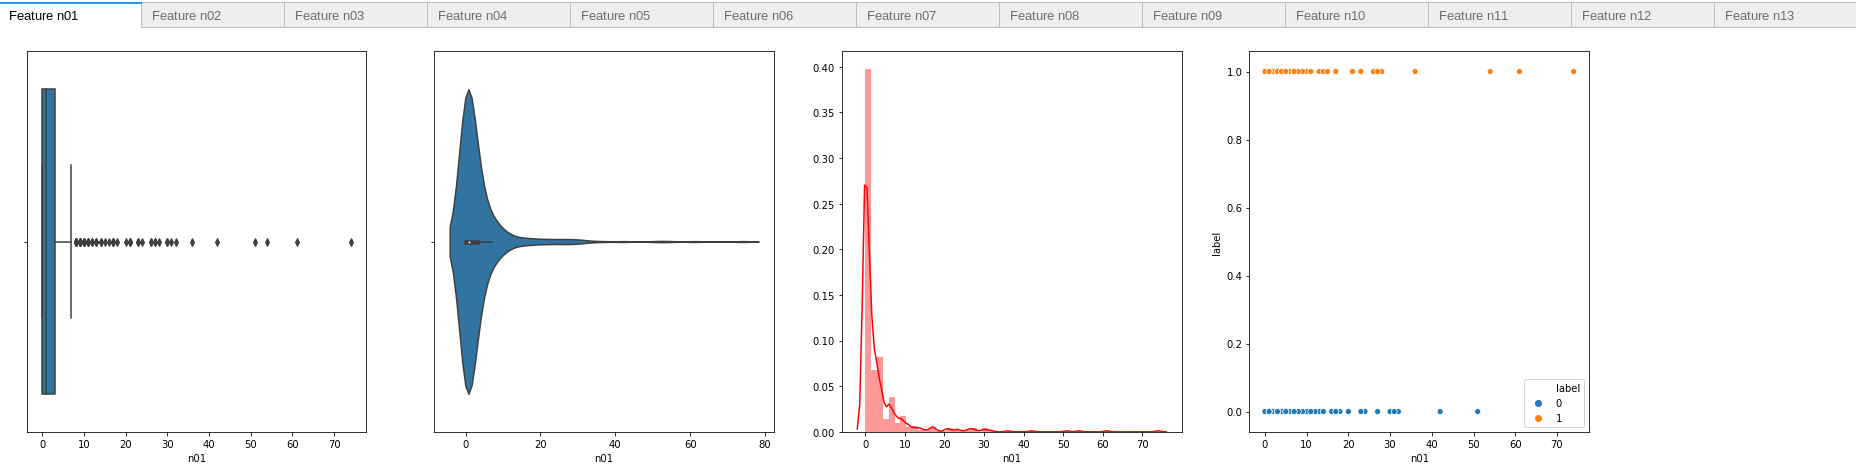
**Figure 4 - Example of plots for Numerical Variable Scaling**

| Numerical Variable | Distribution Type          | Scaling                  |
|--------------------|----------------------------|--------------------------|
| i01                | Exponentially Decreasing   | i01' = i01/(2*SD)        |
| i02                | Truncated Skewed Normal    | i02' = (i02 - median)/SD |
| i03                | Exponentially Decreasing   | i03' = i03/SD            |
| i04                | Truncated Skewed Normal    | i04' = (i04-median)/SD   |
| i05                | Truncated Skewed Normal    | i05' = (i05-median)/SD   |
| i06                | Exponentially Decreasing   | i06' = i06/2*SD          |
| i07                | Exponentially Decreasing   | i07' = i07/2*SD          |
| i08                | Exponentially Decreasing   | i08' = i08/2*SD          |
| i09                | Truncated Skewed Normal    | i09' = (i09-median)/SD   |
| i10                | Sigmoid                    | i10' = i10/Max(i10)      |
| i11                | Truncated Skewed Normal    | i11' = (i11-median)/SD   |
| i12                | Exponentially Decreasing   | i12' = i12/2*SD          |
| i13                | Truncated Skewed Normal    | i13' = (i13-median)/SD   |  
**Table 2 - Scaling Applied to Numeric Features**

## 3.2.2 Categor Features

The dataset contains 26 categorical features, which we labelled from c01 to c26 based on their oder in the dataset and they had all been hashed. We analyzed these features and found that they had very high cardinality. The number of unique categories for each feature is shown below:

In [37]:
cat_measures = load(open('data/model.pickled.normed.filled.masked-060000.cat_measures', 'rb'))

df             = pd.DataFrame.from_dict({ k: [len(v)] for k,v in cat_measures['distinct'].items() }, orient = 'index', columns = ['distinct'])
df['frequent'] = [len(v) for v in cat_measures['frequent'].values()]
df['uncommon'] = [len(v) for v in cat_measures['uncommon'].values()]
df['top five'] = [', '.join(v[:5]) for v in cat_measures['frequent'].values()]

df

,distinct,frequent,uncommon,top five
c01,1460,23,1437,"05db9164, 68fd1e64, 5a9ed9b0, 8cf07265, be589b51"
c02,581,100,481,"38a947a1, 207b2d81, 38d50e09, 1cfdf714, 287130e0"
c03,8381767,45,8381722,"deadbeef, d032c263, 02cf9876, aa8c1539, 9143c832"
c04,1883842,60,1883782,"c18be181, deadbeef, 29998ed1, d16679b9, 85dd697c"
c05,305,13,292,"25c83c98, 4cf72387, 43b19349, 384874ce, 30903e74"
c06,24,7,17,"7e0ccccf, fbad5c96, fe6b92e5, deadbeef, 13718bbd"
c07,12488,62,12426,"1c86e0eb, dc7659bd, 7195046d, 5e64ce5f, 468a0854"
c08,633,17,616,"0b153874, 5b392875, 1f89b562, 37e4aa92, 062b5529"
c09,3,2,1,"a73ee510, 7cc72ec2"
c10,88956,42,88914,"3b08e48b, efea433b, fbbf2c95, fa7d0797, 03e48276"


As shown above, the number of distict categories ranges from 3 to 5894178. Working with this number of cardinal features presents challenges so we examined ways to reduce the cardinality of these features, which included:
1. For each feature, consider the most commonly occurring features in the training set only and encode any other rare categories as one category
2. Use Field-aware Factorization Machines which handle high cardinality data in recommendation and click thoguh rate datases by default
3. Hash the categorical features to a smaller feature space with possible collisions
4. Drop columns with extreme cardinality since these may correspond to features like user IDs or street address that ordinarily may not provide much value to the dataset.

In the end, we chose option 1 because this allowed us to create a dataset that could be used with multiple algorithms while allowing us to shrink the feature space. We also found that for most features. Mnay of the categories appeared in under 1% of the training set (shown below) and so encoding the rare categories into a special category would greatly reduce the potential feature space.

Another issue we had to deal with categorical features, just like with the numeric features was how to deal with null values. Many of the categorical variables had a high number of null values with some columsn having over 40% null values. Below is a breakdown of the percentage of null values for each column. We would need an effective way to deal with these null values

## 3.3 General Feature Engineering


The EDA guided how we went about out feature engineering. The items that we needed to tackle in our feature engineering were:
1. Scale the numeric features so that they are within the same range using an appropriate scaler based on the feature
2. Deal with null values. For the numeric features, null values were replaced with the median while with the categorical features, null values were replaced witha special category, "deadbeef".
3. Reduce the number of categories in each column by encoding rare categories as rarebeef and only keeping those that appear more than 1% of the time
4. One-hot encode the categorical features so that they can be used to train the model
5. Reduce the number of features in the dataset by using a feature selector based on the chi-squared test
6. Oversmaple the data to deal with the issue of unbalanced data which would affect the Logistic Regression and tree-based models
7. Create interaction variables between the features in the dataset

The initial feature engineering is available in the [Engineering-Initial](./book/Engineering-Initial.ipynb) workbook and [engineering.py](./code/engineering.py) python module.

### Numeric Features
The numeric features had different ranges and so it was imprtant to scale them especially when working with linear models like Logistic Regression. As shown in the EDA above, the numeric features had different distributions so they were scaled differently based on this. The scaling used for each numeric feature is shown in section 3.2.1 above.

In [20]:
def allDoStandardize(subset: str, iStep: str):

    """
    Apply standardizations to all numerical features to ensure numerical features have balanced weights.
    Replace all undefined categorical values with deadbeef.

    Input  : Spark Sql Dataframe of original labled data and relevant statistics from training data
    Output : Spark Sql Dataframe of all labeled data with standardized numeric features and filled categoric features
    """
    ...

      # replace all undefined numerical values with the median for that feature
        oData = iData.fillna(num_measures['median'])

      # add standardized numerical feature columns  
        oData = oData.withColumn('n01_standard',((oData['n01']                              )/(2.0*num_measures['stddev']['n01'])))
        oData = oData.withColumn('n02_standard',((oData['n02']-num_measures['median']['n02'])/(1.0*num_measures['stddev']['n02'])))
        oData = oData.withColumn('n03_standard',((oData['n03']                              )/(1.0*num_measures['stddev']['n03'])))
        oData = oData.withColumn('n04_standard',((oData['n04']-num_measures['median']['n04'])/(1.0*num_measures['stddev']['n04'])))
        oData = oData.withColumn('n05_standard',((oData['n05']-num_measures['median']['n05'])/(1.0*num_measures['stddev']['n05'])))
        oData = oData.withColumn('n06_standard',((oData['n06']                              )/(2.0*num_measures['stddev']['n06'])))
        oData = oData.withColumn('n07_standard',((oData['n07']                              )/(2.0*num_measures['stddev']['n07'])))
        oData = oData.withColumn('n08_standard',((oData['n08']                              )/(2.0*num_measures['stddev']['n08'])))
        oData = oData.withColumn('n09_standard',((oData['n09']-num_measures['median']['n09'])/(1.0*num_measures['stddev']['n09'])))
        oData = oData.withColumn('n10_standard',((oData['n10']                              )/(1.0*num_measures['max'   ]['n10'])))
        oData = oData.withColumn('n11_standard',((oData['n11']-num_measures['median']['n11'])/(1.0*num_measures['stddev']['n11'])))
        oData = oData.withColumn('n12_standard',((oData['n12']                              )/(2.0*num_measures['stddev']['n12'])))
        oData = oData.withColumn('n13_standard',((oData['n13']-num_measures['median']['n13'])/(1.0*num_measures['stddev']['n13'])))

        assembler_num = VectorAssembler(inputCols = Common.num_features, outputCol = 'num_features')
        assembler_std = VectorAssembler(inputCols = Common.std_features, outputCol = 'std_features')

        pipeline      = Pipeline(stages = [assembler_num, assembler_std])
        model         = pipeline.fit(oData)

        oData         = model.transform(oData)
        oData         = oData.select('label', 'std_features', *Common.cat_features)

      # replace all undefined categorical values with special term deadbeef
        oData         = oData.fillna('deadbeef', Common.cat_features)
    ...

### Dealing with the Null Values
The null values were dealt with differently for numeric and categorical features. For the numeric features, the null values were imputed using the median in order because most of them were highly skewed. For the cateogircal values, the null values were all encoded to a category labelled **deadbeef**

### Reducing the cardinality of categorical features
As mentioned before, the cardinaly of the categorical features was handled by looking at each feature and encoding all the rare categories to one special category called **rarebeef** [1].

In [21]:
def catDoMeasurement(subset: str, iStep: str):

    """module
    Calculate frequency stats on training data for use in standardization.

    Input  : Raw training dataframe.
    Output : Categorical training stats.
    """    
    ...
        for feature in Common.cat_features:
            cat_measures[feature] = iData.select(feature).groupBy(feature).count() \
                .sort('count', ascending = False) \
                .withColumnRenamed(feature,  'value') \
                .withColumnRenamed('count', 'counts') \
            .toPandas()
    ...

In [ ]:
def catMaskUncommons(subset: str, iStep: str, min: int):
    """
    Mask uncommon categorical feature categories.
    This greatly reduces the number of one-hot encoded features.
    The features in test/valid which were not also in train will be masked as well.

    Input  : Categorical features with Undefined values replaced with a special term : deadbeef. Categorical feature frequency stats.
    Output : Categorical features with Infrequent values replaced with a special term : rarebeef.
    """
    ...
        """
        By using not matching list of frequent categories instead of matching a much longer list of infrequent categories we can
        significantly improve the processing time required on the full dataset
        """

        for feature, measure in Common.cat_measures.items():

            frequent = measure[measure.counts > min].value.to_list()
            oData    = oData.withColumn(feature, when(~oData[feature].isin(*frequent), 'rarebeef').otherwise(oData[feature]))
            count    = oData.select(feature).groupBy(feature).count().count()
            total   += count
    ...

### One-hot encode the categorical features
To be able to use the categorical features in our machine learning algorithms, we had to turn the categorical features into numeric features [1]. To do this, we first used Spark's StringIndexer to create a string index for each of the categories within the features and then one-hot encoded them

In [ ]:
def catDoCodeFeature(subset: str, iStep: str, min: int, fit: bool = False):

    """
    Index and encode all categorical features.
    Generates indicator features for each distinct category withing each respective categorical feature.
    Assemble the one-hot encoded indicators to a categorical feature vector.
    Encoding estimator will be trained on the train set and any features in the test/train that are not present will be dropped.

    Input  : Categorical features with Infrequent values reduced.
    Output : Indicator features for each distinct category assembled into a SparseVector.
    """
    ...
        """
        Use a Spark ML pipeline to chain multiple transformation operations.
        """

        stages   = []
        indexes  = [f'{f}_idx' for f in Common.cat_features]
        vectors  = [f'{f}_vec' for f in Common.cat_features]

        for feature, index, vector in zip(Common.cat_features, indexes, vectors):
            indexer  = StringIndexer(inputCol = feature, outputCol = index)
            encoder  = OneHotEncoderEstimator(inputCols = [indexer.getOutputCol()], outputCols = [vector], dropLast = False)
            stages  += [indexer, encoder]

        assembler = VectorAssembler(inputCols = vectors, outputCol = 'cat_features')
        stages   += [assembler]

        encoding_pipe  = Pipeline(stages = stages)
        encoding_model = encoding_pipe.fit(iData)

        encoding_model.save(oPipe)

        timePrint(f'Building Model : Done')

    Common.encode_model = PipelineModel.load(oPipe)

    if  iData != None and not exists(oFile):

        oData  = Common.encode_model.transform(iData)
        oData  = oData.select(['label', 'std_features', 'cat_features'])
    ...

#### Feature Selection
After carrying out the other feature engineering steps, we had a number of features. To determine which ones we should keep and to reduce dimensionality, we used Pyspark's ChiSqSelector to choose the best features. This uses the Chi-Squared Test of Independence to select the best features based on the outcome variable. The variant we used chooses the top features with the highest predictive power in relation to the outcome variable.

In [ ]:
def catDoPickFeature(subset: str, iStep: str, top: int, fit: bool = False):

    """
    Use Chi-Square test to select the top N encoded categorical features.
    Assemble picked features into a new vector.

    Input  : The one-hot encoded categorical features in cat_features SparseVector.
    Output : The top N categorical features in top_features SparseVector.
    """
    ...
        """
        Perform the Chi-Square test on the training dataset to select the highest N correlated features.
        """

        timePrint(f'Building Model : {oPipe}')

        selector       = ChiSqSelector(numTopFeatures = top, featuresCol = 'cat_features', outputCol = 'top_features', labelCol = 'label')
        selector_pipe  = Pipeline(stages = [selector])
        selector_model = selector_pipe.fit(iData)

        selector_model.save(oPipe)

        timePrint(f'Building Model : Done')

    Common.select_model = PipelineModel.load(oPipe)

    if  iData != None and top:

        oData  = Common.select_model.transform(iData)
    ...

### Initial Feature Engineering Recipe

In [8]:
min = 60000 # minimum occurance threshold for each categorical feature category,
            # generates 1150 one-hot encoded categorical features
top =   987 # maximum selection threshold for ChiSquareSelector of one-hot encoded
            # categorical features : 987 top categorical features + 13 numerical
            # features = 1000 total features

In [ ]:
Engineering.numDoMeasurement(subset = 'train', iStep = f'', fit = True)

Engineering.numDoStandardize(subset = 'train', iStep = f'')
Engineering.numDoStandardize(subset = 'tests', iStep = f'')
Engineering.numDoStandardize(subset = 'valid', iStep = f'')

Engineering.catFillUndefined(subset = 'train', iStep = f'normed')
Engineering.catFillUndefined(subset = 'tests', iStep = f'normed')
Engineering.catFillUndefined(subset = 'valid', iStep = f'normed')

Engineering.catFindFrequents(subset = 'train', iStep = f'normed.filled', min = min, fit = True)

Engineering.catMaskUncommons(subset = 'train', iStep = f'normed.filled', min = min)
Engineering.catMaskUncommons(subset = 'tests', iStep = f'normed.filled', min = min)
Engineering.catMaskUncommons(subset = 'valid', iStep = f'normed.filled', min = min)

Engineering.catDoCodeFeature(subset = 'train', iStep = f'normed.filled.masked-{min:06d}', fit = True)
Engineering.catDoCodeFeature(subset = 'tests', iStep = f'normed.filled.masked-{min:06d}')
Engineering.catDoCodeFeature(subset = 'valid', iStep = f'normed.filled.masked-{min:06d}')

Engineering.catDoPickFeature(subset = 'train', iStep = f'normed.filled.masked-{min:06d}.encode', top = top, fit = True)
Engineering.catDoPickFeature(subset = 'tests', iStep = f'normed.filled.masked-{min:06d}.encode', top = top)
Engineering.catDoPickFeature(subset = 'valid', iStep = f'normed.filled.masked-{min:06d}.encode', top = top)

Engineering.allDoPackFeature(subset = 'train', iStep = f'normed.filled.masked-{min:06d}.encode.picked-{top:06d}', fit = True)
Engineering.allDoPackFeature(subset = 'tests', iStep = f'normed.filled.masked-{min:06d}.encode.picked-{top:06d}')
Engineering.allDoPackFeature(subset = 'valid', iStep = f'normed.filled.masked-{min:06d}.encode.picked-{top:06d}')

In [ ]:
Engineering.toyTakeSubSample(subset = 'train', iStep = f'normed.filled.masked-{min:06d}.encode.picked-{top:06d}.packed', len = 8000)
Engineering.toyTakeSubSample(subset = 'tests', iStep = f'normed.filled.masked-{min:06d}.encode.picked-{top:06d}.packed', len = 1000)
Engineering.toyTakeSubSample(subset = 'valid', iStep = f'normed.filled.masked-{min:06d}.encode.picked-{top:06d}.packed', len = 1000)

## Advanced Feature Engineering

### Create Interaction Variables
Finally, we also explored the creation of interaction variables to add more features and to capture possible interactions between the variables. The interaction features we created were between the numeric and the categorical features.

The advanced feature engineering including interactions are available in the [Engineering-Advanced](./book/Engineering-Advanced.ipynb) workbook and [interactions.scala](./code/interactions.scala) scala module.

In [ ]:
def allJoinInteract(subset: String, iStep: String) {

    /*
        This had to be written in Scala as PySpark implementation of SparkML interactions transformer was not available.
        Add interactions between the categorical indicators and numerical features.
        Use SparkML Interactions feature transformer to calculate the product of all 13 numerical features with the arbitary number of categorical indicators.

        Input  : std_features and cat_features
        Output : cxn_features SparseVector
    */

    var iData: DataFrame = taskStarting("action", "Numerical vs Categorical Interactions", subset, iStep)
    var oData: DataFrame = null

    if (iData != null) {
        val interaction = new Interaction()
            .setInputCols(Array("std_features", "cat_features"))
            .setOutputCol("cxn_features")

        oData = interaction.transform(iData)
    }

    taskStopping("action", "Numerical vs Categorical Interactions", subset, oData)
}


### Oversample the data

The data was imbalanced and so it was necessary to balance it before using the models given that there was a 3 to 1 ratio between negative and positive classes. We used the oversampling technique to create more positive examples from the same data resulting in a close to 1 to 1 ratio in the end. This allowed us to train tree-based classifiers that would suffer from the class imbalance.

In [25]:
def oversampleData(train):
    '''
    Takes in a train dataframe and oversamples the positive variables.
    
    Returns the oversampled datframe
    '''

    # getthe counts for each class
    label_counts_df = train.groupby('label').count().toPandas()
    negative_count = label_counts_df.at[0, 'count']
    positive_count = label_counts_df.at[1, 'count']

    # Calculate the number of extra data points needed and the oversample rate
    extra = negative_count - positive_count
    print(f'Extra data points = {extra}')


    resample_rate = extra/positive_count

    print(f'The resample rate is {resample_rate}')

    # use resample rate to create more positive examples
    extra_positives = train.filter(train['label']==1).sample(withReplacement=True, fraction=resample_rate)

    # add the new examples to the dataset
    oversampled_train = train.union(extra_positives)
    oversampled_train = oversampled_train.sample(withReplacement = False, fraction = 1.0)
    
    return oversampled_train

__References - Section 3__

[1] J. de Wit, “Deep-Learning-for-Criteo-Documentation,” GitHub, 30-Sep-2014. [Online]. Available: https://github.com/juliandewit/kaggle_criteo. [Accessed: 11-Dec-2019]

# __Section 4__ - Algorithm Implementation

## 4.1 Homegrown Implementation from Scratch - Who needs libraries anyway?

The code for the homegrown SVM can be found in the [Homegrown Algorithm - Kombucha](./book/KombuchaModel.ipynb). 

- Challenges: 
     That Gradient Descent! Working with Hinge Loss presents a new type of challenge: the function it's not entirely convex. We were able to code the gradient using similar techniques as the ones we did for Linear Regression wit L1 regularization: We use sub-gradients, which converge into the solution. The next problem was the decision of doing Batch Gradient Descent vs. Stochastic Gradient Descent. We decided to do Batch Gradient Descent, and immediatley understood why ML on Spark uses SGD - you sacrifice number of steps for time. As we seen in the Kombucha Notebook, the amount of time of GD it's way longer on big data sets compare to SGD.
     
     Another challenge is the Algorithm perse. We implemented a linear SVM, but from our EDA, we know that the data is not separable in a way that a linear classifier could be used. SVM provides an answer for this problem: the introduction of the kernel trick to change the perspective plane of data [__2__]. However, Spark doesn't provide with an implementation of basic kernels like Gaussian. This it's still in development, although we believe that it will be left behind as they move towards implementing Neural Networks and Deep Learning models.
     
- Validation:
    We were able to achieve a similar level of AUC using our model on the test set, for both the toy model and the entire dataset, which is a great validation of the concepts. However, our implementation it's still far from being perfect - our training times it's at least 3 times worst that the ML implementation. 
    
- Implementation:
    All the implementations details are in [Homegrown Algorithm - Kombucha](./book/KombuchaModel.ipynb). We start from a baseline (either the mean of the labels or decide that all labels are one of the classes), and then we update the gradient at each iteration. We were able to use the toy as a some sort of development set to Fine Tune the Regularization Parameter. We also observe that the process takes time to converge, and that the graphs are not smooth - again a byproduct of using subGradients for training.

## 4.2 Scaled Classification on Full Dataset using Spark ML

On the full dataset, we applied a scalable version of our algorithm from Spark MLLib together with other algorithms. We used Logistic Regression as our baseline. and thereafter applied our main algorithm, the Linear SVM and other tree based models.

|             Classifier 	| Parameters                        	| Feature Count              	| Engineering Notes                                                                                       	| Train AUC 	| Validation AUC 	| Test AUC 	|
|-----------------------:	|-----------------------------------	|----------------------------	|---------------------------------------------------------------------------------------------------------	|-----------	|----------------	|----------	|
|     LogisticRegression 	| <ul> <li>maxIter = 100</li> </ul> 	| 1000 = 13 + 987            	| <ul> <li>baseline 13 num + 987 cat features</li> </ul>                                                  	| 73.64%    	| 73.63%         	| 73.65%   	|
|              LinearSVC 	| <ul> <li>maxIter = 100</li> </ul> 	| 1000 = 13 + 987            	| <ul> <li>baseline 13 num + 987 cat features</li> </ul>                                                  	| 68.69%    	| 68.64%         	| 68.70%   	|
| DecisionTreeClassifier 	| <ul> <li>maxIter = 100</li> </ul> 	| 1000 = 13 + 987            	| <ul> <li>baseline 13 num + 987 cat features</li> </ul>                                                  	| 53.97%    	| 53.97%         	| 53.97%   	|
| RandomForestClassifier 	| <ul> <li>numTrees = 30</li> </ul> 	| 1000 = 13 + 987            	| <ul> <li>baseline 13 num + 987 cat features</li> </ul>                                                  	| 70.06%    	| 70.05%         	| 70.08% 	|
|          GBTClassifier 	| <ul> <li>maxIter = 10</li> </ul>  	| 1000 = 13 + 987            	| <ul> <li>baseline 13 num + 987 cat features</li> </ul>                                                  	| 72.26%  	|     72.25%     	|  72.30%        	|
|     LogisticRegression 	| <ul> <li>maxIter = 100</li> </ul> 	| 16,463 = 13 + 987 + 10,231 	| <ul> <li>baseline 13 num + 987 cat features</li> <li>additiona 13 num x 987 cat interactions</li> </ul> 	| 75.04%    	| 74.99%         	| 75.01%   	|
|     LogisticRegression 	| <ul> <li>maxIter = 100</li> </ul> 	| 36,168 = 13 + 36,155       	| <ul> <li>extended 13 num + 36155 cat features</li> </ul>                                                	| 77.57%    	| 77.48%         	| 77.49%   	|
|     LogisticRegression 	| <ul> <li>maxIter = 100</li> </ul> 	| 56,507 = 13 + 56,494       	| <ul> <li>extended 13 num + 56494 cat features</li> </ul>                                                	| 77.88%    	| 77.75%         	| 77.75%   	|
|     LogisticRegression 	| <ul> <li>maxIter = 100</li> </ul> 	| 159,275 = 13 + 159,262     	| <ul> <li>extended 13 num + 159262 cat features</li> </ul>                                               	| 78.41%    	| 78.09%         	| 78.08%   	|

As shown above, none of the algorithms was able to beat the baseline set by the Logistic Regression classifier.With the closest algorithm being the Gradient Boosting Tree classifier.

Discussion about L1/L2 (elasticnet) and lambda (regParam) for Logistic Regression here. - **LAURA** reword

|         Classifier 	| Parameters                                                                                                            	| Feature Count   	| Modeling Notes                              	| Train AUC 	| Validation AUC 	| Test AUC 	|
|-------------------:	|-----------------------------------------------------------------------------------------------------------------------	|-----------------	|---------------------------------------------	|-----------	|----------------	|----------	|
| LogisticRegression 	| <ul> <li>maxIter = 100</li> <li>family =  binomial </li> <li>elasticNetParam  = 0.0</li> <li>regParam = 0.0</li></ul> 	| 1000 = 13 + 987 	| No Regularization                           	| 73.64%    	| 73.63%         	| 73.65%   	|
| LogisticRegression 	| <ul> <li>maxIter = 100</li> <li>family =  binomial </li> <li>elasticNetParam = 0.0</li> <li>regParam = 0.1</li></ul>  	| 1000 = 13 + 987 	| Ridge : L2 Regularization with Lambda = 0.1 	| 72.63%    	| 72.63%         	| 72.64%   	|
| LogisticRegression 	| <ul> <li>maxIter = 100</li> <li>family =  binomial </li> <li>elasticNetParam  = 1.0</li> <li>regParam = 0.1</li></ul> 	| 1000 = 13 + 987 	| Lasso : L1 Regularization with Lambda = 0.5 	| 50.00%    	| 50.00%         	|  50.00%  	|

<figure>
  <img src="assets/OverUnderFitting.png" width="550">
    <figcaption> <b>Over and Under Fitting Tradeoff (1)</b> </figcaption>
</figure>

What we are seeing so far, I think, is that we have not yet entered 'overfitting' territory. I.e. we are still very close between validation and training sets, which says that we are not overfitting. Because we are not overfitting, the lambda will not help us.

The alpha probably does no good because we've already feature-engineered the heck out of the features. Increasing alpha (increasing L1) means we are taking more features out, which decreases our results.


__References - Section 4__

(1) https://www.jeremyjordan.me/evaluating-a-machine-learning-model/


# __Section 5__ - Course Concepts

**LAURA** to start input here

1. scalability / time complexity / I/O vs Memory

#### 2. One Hot Encoding / vector embeddings / feature selection  

Section 3.3 Discussed the one-hot encoding and feature selection. Although we discussed this briefly in the course, this project allowed us to delve into the practicalities of feature engineering in detail. If every unique category in the categorical features were one-hot encoded, there would be approximately 33 million features, and an obvious issue with dimensionality, not to mention that these are extremely sparse and managing that many features is un-realistic. In order to address the issue, we looked at many different solutions, always aiming to reduce the number of categorical features but retain as much of the inherent information in the data as possible. Binning and using a Chi-Square selector turned out to be good ways to reduce the categorical features in a way that preserved information. We also looked at interactions between the numeric and categorical features as a way to 'add back' information that may have been lost during the categorical feature reduction phase. Finally, we saved the features as sparse vectors and used sparse processing functions - this helped us to train the models in a reasonable amount of time.

3. Broadcasting / Caching / Lazy Evaluation

#### 4. Batch vs. Stochastic Gradient Descent

This assignment finally uncovered the truth that we started to discuss during our class: The differences on scalability between Batch Gradient Descent and Stochastic Gradient Descent. As discussed on our Homegrown Model (Kambucha), we decided to implement a normal batch Gradient Descent, where we transverse the entire dataset once to find the total gradient, and then we update the weights in one go. The pros of doing this approach, is that convergence needs **less** steps than Stochastic Gradient Descent, but each iteration it's slower. In fact, the time complexity of GD it's related to the tolerance of the algorithm $O(nClog(1/\epsilon)$, where C it's a constant time [__1__]. So, even though it's easier to implement, it's overall less efficient when we scale up the data.

On the other hand, almost all the MLLib packages of Spark use Stochastic Gradient Descent as they go to algorithm for good reasons: the model it's almost linear with respect of the tolerance with a time complexity of $O(C/\epsilon)$. The effort placed into coding a SGD implementation it's well worth the time gained in training for many of the more complicated models out there. So, even though we sacrifice steps, we gain efficiency in time. 

__References - Section 5__

[1]: A. Zisserman, "Lecture 2: The SVM classifier". Oxford. Retrieved from http://www.robots.ox.ac.uk/~az/lectures/ml/lect2.pdf

#### 5. Bias-Variance Tradeoff

We explored this when we were running our models, first when creating the baseline with Logisitic Regression. Here we tried to examine the effect of reguliraztion, both L1 and L2 and found that there were no improvements with regularization. Also since the area under the curve (AUC) did not vary much from train to test, we were able to conclude that we were not underfitting. Given that we received a reasonable AUC, which was above 50, we were also comfortable ruling out bias.

Further, when working with decsion trees, we run into issues where the model was unable to fit the data well. Again, since our train and development AUC scores were similar, we were able to rule out variance. However the scores on train development and test sets were all low and close to 50 which is not very different from random guessing. To mitigate this, we used Random Forests and Gradient Boosted Trees which use an ensemble of trees and hence avoid overfitting trees while using many tress and combinign their predictions also avoids bias underfitting.